In [112]:
def spatial_decomposition(X, unit_cell, *args):
    '''
    % decomposite the spatial domain into cells D with vertices V,
    %
    % Output
    %  V - list of vertices
    %  F - list of faces
    %  I_FD - incidence matrix between faces to cells

    % compute voronoi decomposition
    % V - list of vertices of the Voronoi cells
    % D   - cell array of Vornoi cells with centers X_D ordered accordingly
    '''
    # Imports
    import getopt
    from numpy import cumsum, zeros, unique, sort
    from spatialDecompFunctions import generateUnitCells
    from scipy.spatial import Voronoi
    from scipy.sparse import csr_matrix, coo_array
    from orix.utilities.utilities import uniquerows

    if unit_cell.all() == None:
        unit_cell = calcUnitCell(X)

    if args[0] == 'unit_cell':

        # compute the vertices
        [V, faces] = generateUnitCells(X, unit_cell, args[:])
        # NOTE: V and faces do not give exact values as compared to the MATLAB
        # implementation. However, Eric and Rohan have confirmed that V and faces
        # at least have the same shape as the MATLAB implementation.

        D = np.empty(len(X),dtype=object)

        for k in range(X.shape[0]):
            D[k] = faces[k, :]

    else:    
        var_arg_in = args[0]
        dummy_coordinates = calcBoundary(X, unit_cell, var_arg_in)

        vor = Voronoi(np.vstack([X, dummy_coordinates]), 
                        qhull_options = 'Q5 Q6 Qs') #,'QbB'

        V = vor.vertices
        D = vor.regions
        D = D[0:X.shape[0]]

    # now we need some adjacencies and incidences
    iv = np.hstack(D)        # nodes incident to cells D
    iid = zeros(len(iv), dtype=np.int64)   # number the cells

    # Some MATLAB stuff goin on here... : p = [0; cumsum(cellfun('prodofsize',D))];
    D_prod = matlab_prod_of_size(D)
    p = np.hstack([0, np.cumsum(D_prod)-1])

    # original matlab: for k=1:numel(D), id(p(k)+1:p(k+1)) = k; end
    for k in range(len(D)):
        iid[p[k]+1 : p[k+1]] = k

    # next vertex
    # indx = 2:numel(iv)+1;
    ind_x = np.arange(1,len(iv)+1)
    # indx(p(2:end)) = p(1:end-1)+1;
    ind_x[p[1:]] = p[0:-1] + 1
    # ivn = iv(indx);
    iv_n = iv[ind_x]

    # edges list
    F = np.vstack([iv[:], iv_n[:]]).T

    # should be unique (i.e one edge is incident to two cells D)
    F, _, ie = uniquerows(F)

    # faces incident to cells, F x D
    #original matlab: I_FD = sparse(ie,id,1); 
    # Matlab stores as csr matrix, so we use this class below
    data = np.ones(np.shape(ie))
    I_FD = csr_matrix( (data, (ie, iid)))
    #I_FD = csr_matrix( (data, (ie, iid)), shape=[ie.shape[0], ie.shape[0]]) # could also use csc_matrix() if it improves
                                # performance !
    '''
    NOTE: may need to use different sparse matrix. The matrix is incorrect as
          compared to the MATLAB implementation.
          
          Could also be causing problems in the Householder matrix initialization.
    '''
    

    return V, F, I_FD

def calcBoundary(X, unit_cell, var_arg_in='hull'):
    '''
    dummy coordinates so that the voronoi-cells of X are finite

    Inputs:
    --------------
    X : n x 2 numpy array of [x,y] vertex coordinates

    unit_cell : n x 2 numpy array of [x,y] coordinates of "pixel" boundary (e.g. hexagon or square)

    var_arg_in : ???
    ???


    Outputs:
    --------------
    ??? : ???
    ???

    Dependencies:
    --------------
    import getopt
    import numpy as np
    from scipy.spatial import ConvexHull
    from numpy import arctan2, diff, cumsum, matrix, squeeze, unique
    from statistics import mean
    from math import sqrt, floor, copysign
    '''
    # Imports
    import getopt
    import numpy as np
    from scipy.spatial import ConvexHull
    from numpy import arctan2, cumsum, matrix, squeeze, unique, linspace
    from statistics import mean
    from math import sqrt, floor, copysign
    from orix.quaternion.rotation import Rotation
    import orix.vector as vect
    from orix.utilities.utilities import uniquerows
    import alphashape
    
    from spatialDecompFunctions import householderMatrix, translationMatrix#, erase_linearly_dependent_points

    dummy_coordinates = []

    boundary = str(var_arg_in)

    if boundary.isalpha():
        
        if boundary.lower() == 'tight':
            
            k = alphashape.alphashape(X, 0.95) #TODO: 0.95 matches mtex, but this would be a good user variable
            k2 = list(zip(*k.exterior.coords.xy))
            locations = []
            for item in k2:
                locations.append(np.where(np.all(item==X, axis=1)))
            locations = np.squeeze(locations)
            
            bounding_X  = erase_linearly_dependent_points(X, locations)
            
            import matplotlib.pyplot as plt
            plt.figure()
            plt.plot(bounding_X[:,0], bounding_X[:,1])
            plt.show()


        if (boundary.lower() == 'hull' or
            boundary.lower() == 'convexhull'):
            
            k = ConvexHull(X)
            k = k.vertices
            
            bounding_X  = erase_linearly_dependent_points(X, k)
            
            import matplotlib.pyplot as plt
            plt.figure()
            plt.plot(bounding_X[:,0], bounding_X[:,1])
            plt.show()
            
        elif boundary.lower() == 'cube':
            # set up a rectangular box
            envelope_X = [np.amin(X), np.amax(X)]
            bounding_X = [
                envelope_X[1], envelope_X[3],
                envelope_X[2], envelope_X[3],
                envelope_X[2], envelope_X[4],
                envelope_X[1], envelope_X[4],
                envelope_X[1], envelope_X[3],
                ]

        else:
            raise ValueError('Unknown boundary type. Available options are \
            ''hull'', ''convexhull'' and ''cube''.')

    elif isinstance(boundary, float):
        bounding_X = boundary
    
    radius = np.mean(np.sqrt(np.sum( (unit_cell**2), axis=1)))
    
    edge_length = ((matlabdiff(bounding_X)**2).sum(axis=1, keepdims=True))**0.5 
    #edgeLength = sqrt(sum(diff(boundingX).^2,2));
    
    # fill each line segment with nodes every 20 points (in average)
    nto = np.int32(np.fix( (edge_length>0)*4 ))

    #nto = floor( edge_length*(2*radius) )
    #nto = fix((edgeLength>0)*4); fix(edgeLength*(2*radius));

    csum = np.int32(cumsum(np.vstack([0, nto+1])))

    print('pre-lhs')
    print(bounding_X)
    
    bounding_X = left_hand_assignment(bounding_X, csum)
    
    print('post-lhs')
    print(bounding_X)
    
    # interpolation
    for k in range(nto.shape[0]):
        for dim in range(nto.shape[1]+1):
            
            print('loop', k, dim)
            print(csum[k], csum[k+1])
            
            bounding_X[csum[k]:csum[k+1], dim] = linspace(
                bounding_X[csum[k],dim],
                bounding_X[csum[k+1], dim],
                nto[k,0]+2
            )

    print('post-expand')
    print(bounding_X)
    
    # homogeneous coordinates
    X = np.hstack([X, np.ones([X.shape[0],1])])
    bounding_X = np.hstack([bounding_X, np.ones([bounding_X.shape[0],1])])

    # direction of the edge
    edge_direction = matlabdiff(bounding_X)
    edge_angle = arctan2( edge_direction[:, 1], edge_direction[:,0] )
    edge_length = np.sqrt( (edge_direction**2).sum(axis = 1, keepdims=True))

    # shift the starting vertex
    r = Rotation.from_axes_angles(vect.Vector3d([0, 0, 1]), edge_angle)
    a = vect.Vector3d([0, radius, 1])
    b_X = np.squeeze(r * a)
    offset_X = np.squeeze(b_X.data) - np.squeeze(bounding_X[0:-1, :])
        
    dummy_coordinates = np.array([[0,0]])
    for k in range(bounding_X.shape[0]-1):

        # mirror the point set X on each edge
        p_X = np.matmul(X,
            -1*( 
                np.matmul(
                    np.matmul(
                        translationMatrix(offset_X[k, :]),
                        householderMatrix(edge_direction[k, :])
                    ), 
                    translationMatrix(offset_X[k, :])
                ).T
            )
        )

        '''
        NOTE FROM ERIC AND ROHAN: We are having problems with getting the proper
        dummy_coordinates. The bounding box only has 2 of 4 lines, we believe
        this is where the problem is. MATLAB is doing bizarre things with the
        element-wise division!!!!! We need to contact somebody about this behavior.
        Python is doing what we expect but it's not the right answer.
        
        UPDATE FROM ERIC: Changing the order of operations in Python gives the same result as Matlab.
        '''

        # distance between original and mirrored point
        dist = np.sqrt(np.sum((X[:,0:-1]-p_X[:,0:-1])**2, axis=1))

        intend_X = 2. * radius * copysign(1, edge_direction[k,0:1])

        # now try to delete unnecessary points
        m = 2
        tmp_X = p_X[dist < m*radius,0:-1]
        while edge_length[k] / tmp_X.shape[0] >= radius/3:

            tmp_X = p_X[dist < m*radius,0:2]

            right = np.matmul(tmp_X - np.tile( bounding_X[k, 0:2]   - intend_X, [np.shape(tmp_X)[0], 1]), edge_direction[k, 0:2].T) < 0
            left  = np.matmul(tmp_X - np.tile( bounding_X[k+1, 0:2] + intend_X, [np.shape(tmp_X)[0], 1]), edge_direction[k, 0:2].T) > 0

            tmp_X = tmp_X[~np.any(np.vstack([right, left]), axis=0), :]

            if m < 2**7:
                m = m*2
            else:
                m = m+10

        if tmp_X.size > 0:
            dummy_coordinates = np.vstack([dummy_coordinates, tmp_X])

    dummy_coordinates, _, _ = uniquerows(dummy_coordinates[1:,:])
    
    return dummy_coordinates

def matlab_prod_of_size(D):
    '''
    Testing:
    test1 = [[1, 2, 3], [1, 2], [1]]
    matlab_prod_of_size(test1)
    '''
    prod_of_size = []
    for elem in D:
        prod_of_size.append(len(elem))
    return prod_of_size

def erase_linearly_dependent_points(X, k):
    '''
    subfunction to remove linearly dependent points.

    Inputs:
    --------------
    k : ???
        ???

    Outputs:
    --------------
    ??? : ???
        ???

    Dependencies:
    --------------
    from scipy.spatial import ConvexHull
    '''
    from orix.utilities.utilities import regularPoly
    import numpy as np
    from scipy.spatial import ConvexHull
    from orix.utilities.utilities import sortrows
    import alphashape

    # erase all linear dependent points
    angle = np.arctan2(X[k[0:-1],0]-X[k[1:],0],
        X[k[0:-1],1]-X[k[1:],1])
    test = np.abs(np.diff(angle))>np.spacing(1.0)
    k2 = k[np.concatenate([[True], test, [True]])]
    
    # Build the coord set of the convex hull
    # Pad on the end->start connection to close hull
    # If the origin is contained as a boundary point
    # then we need to shift the array values so the origin
    # is the end->start wrap
    boundingX = X[k2,:]
    
    zero_row = -1
    for i in range(boundingX.shape[0]):
        if np.all(boundingX[i]==0):
            zero_row = i
    
    if (zero_row != -1):
        boundingX = np.roll(boundingX, -zero_row, axis=0)
    
    boundingX = np.vstack([boundingX , boundingX[0,:] ])
 
    return boundingX

def left_hand_assignment(X, a):
    '''
    Attempts to replicate MATLAB left-hand assignment for a 2D array.
 

    Inputs:
    --------------
    X : 2D numpy array
 

    Outputs:
    --------------
    X : 2D numpy array
        This is different from the X passed in, it will return a larger array with
        more zeros.
 
    Dependencies:
    --------------
    import numpy as np
    '''
 
    import numpy as np
    import warnings
    
    if a.dtype != 'int':
        warnings.warn('parameter ''a'' must be of integer type. Converting ''a'' into integers and moving on...')

    a = np.int32(a)

    bound_X_init = X
    ncols = X.shape[1]
 
    max_a = np.amax(a)
    bound_X_fin = np.zeros([max_a+1, ncols])
  
    bound_X_fin[0:bound_X_init.shape[0], :] = bound_X_init
    
    #print('fin')
    #print(bound_X_fin)
 
    for i, elem in enumerate(a[0:-1]):
    #    print('on loop iteration')
    #    print(i)
    #    print('fin_new')
        bound_X_fin[elem, :] = bound_X_init[i, :]
    #    print(bound_X_fin)

    #print(bound_X_fin.shape[0])
    
    return bound_X_fin

def matlabdiff(myArray):
    return myArray[1:,:] - myArray[0:-1,:]


In [ ]:
args = (['hull'])

import numpy as np
X = np.loadtxt('spatialDecomposition_input_X.csv', delimiter=',', dtype=float)
unit_cell = np.loadtxt('spatialDecomposition_input_unitCell.csv', delimiter=',', dtype=float)

V, F, I_FD = spatial_decomposition(X, unit_cell, 'tight')

#return V, F, I_FD

In [ ]:
F_out = np.loadtxt('spatialDecomposition_output_F.txt', delimiter=',', dtype=float)
V_out = np.loadtxt('spatialDecomposition_output_V.txt', delimiter=',', dtype=float)

import scipy.io
I_FD_out = scipy.io.loadmat('spatialDecomposition_output_I_FD.mat')
I_FD_out = I_FD_out['I_FD']

print(np.shape(F_out))
print(np.shape(F))
print(np.shape(V_out))
print(np.shape(V))
print(np.shape(I_FD_out))
print(np.shape(I_FD))

In [ ]:
radius = np.mean( sum( (unit_cell**2) ** 0.5 ) )
print(radius)
np.mean(np.sqrt(np.sum( (unit_cell**2), axis=1)))

In [ ]:
# interpolation

for k in range(nto.shape[0]):
    for dim in range(nto.shape[1]):
        #print(nto[k]+2)
        bounding_X[csum[k]:csum[k+1], dim] = linspace(
            bounding_X[csum[k],dim],
            bounding_X[csum[k+1], dim],
            nto[k,dim]+1
        )

In [4]:
import alphashape
import numpy as np
X = np.loadtxt('spatialDecomposition_input_X.csv', delimiter=',', dtype=float)
k = alphashape.alphashape(X, 0.95)
print(k)

POLYGON ((22.2499305859333 146.790847991732, 22.7499290260666 146.790847991732, 23.2499274661999 146.790847991732, 23.7499259063333 146.790847991732, 24.2499243464666 146.790847991732, 24.7499227865999 146.790847991732, 25.2499212267333 146.790847991732, 25.7499196668666 146.790847991732, 26.2499181069999 146.790847991732, 26.7499165471333 146.790847991732, 27.2499149872666 146.790847991732, 27.7499134273999 146.790847991732, 28.2499118675333 146.790847991732, 28.7499103076666 146.790847991732, 29.2499087477999 146.790847991732, 29.7499071879333 146.790847991732, 30.2499056280666 146.790847991732, 30.7499040681999 146.790847991732, 31.2499025083333 146.790847991732, 31.7499009484666 146.790847991732, 32.2498993885999 146.790847991732, 32.7498978287333 146.790847991732, 33.2498962688666 146.790847991732, 33.7498947089999 146.790847991732, 34.2498931491333 146.790847991732, 34.7498915892666 146.790847991732, 35.2498900293999 146.790847991732, 35.7498884695333 146.790847991732, 36.2498869

In [6]:
k.coords

NotImplementedError: Component rings have coordinate sequences, but the polygon does not

In [52]:
x,y  = k.exterior.coords.xy
xy = np.array(list(zip(*k.exterior.coords.xy)))

In [53]:
xy[2]


array([ 23.24992747, 146.79084799])

In [54]:
X[195]

array([ 0.24999922, 84.43721345])

In [63]:
np.where(xy[1]==X)

(array([   339,    679,   1019,   1359,   1699,   2039,   2379,   2719,
          3059,   3399,   3739,   4079,   4419,   4759,   5099,   5439,
          5779,   6119,   6459,   6799,   7139,   7479,   7819,   8159,
          8499,   8839,   9179,   9519,   9859,  10199,  10539,  10879,
         11219,  11559,  11899,  12239,  12579,  12919,  13259,  13599,
         13939,  14279,  14619,  14959,  15299,  15301,  15303,  15305,
         15307,  15309,  15311,  15313,  15315,  15317,  15319,  15321,
         15323,  15325,  15327,  15329,  15331,  15333,  15335,  15337,
         15339,  15341,  15343,  15345,  15347,  15349,  15351,  15353,
         15355,  15357,  15359,  15361,  15363,  15365,  15367,  15369,
         15371,  15373,  15375,  15377,  15379,  15381,  15383,  15385,
         15387,  15389,  15391,  15393,  15395,  15397,  15399,  15401,
         15403,  15405,  15407,  15409,  15411,  15413,  15415,  15417,
         15419,  15421,  15423,  15425,  15427,  15429,  15431, 

In [59]:
np.shape(xy)

(967, 2)

In [60]:
np.shape(X)

(106760, 2)

In [64]:
xy==X

/var/folders/nz/l5ynytfs6sj2drjd5cs1wckc0000gn/T/ipykernel_1871/910372688.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  xy==X


False

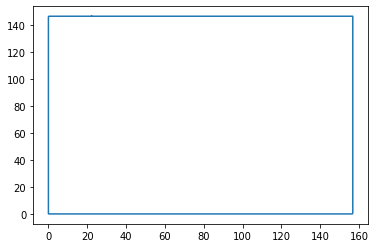

In [111]:
k = alphashape.alphashape(X, 0.5)
k2 = list(zip(*k.exterior.coords.xy))
locations = []
for item in k2:
    locations.append(np.where(np.all(item==X, axis=1)))
locations = np.squeeze(locations)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(X[locations,0], X[locations,1])
#plt.plot(bounding_X[:,0], bounding_X[:,1])
plt.show()

#bounding_X  = erase_linearly_dependent_points(X, locations)



In [110]:
np.where(np.all(k2[50]==X, axis=1))

(array([32299]),)

In [103]:
np.array(k2[1])

array([ 22.74992903, 146.79084799])

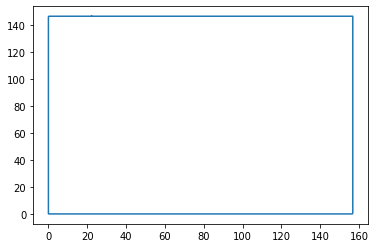

In [85]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(k2[:,0], k2[:,1])
#plt.plot(bounding_X[:,0], bounding_X[:,1])
plt.show()

(967, 1, 1)

(966,)

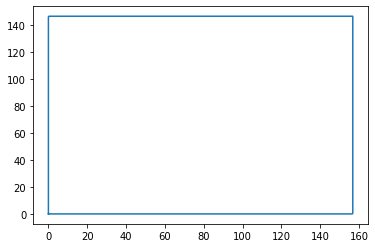

In [77]:
from scipy.spatial import ConvexHull
k = ConvexHull(X)
k = k.vertices

bounding_X  = erase_linearly_dependent_points(X, k)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(bounding_X[:,0], bounding_X[:,1])
plt.show()